# Intermediate Machine Learning: Assignment 5

**Deadline**

Assignment 5 is due Thursday, December 4 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please convert to html and then print to pdf. (You may want to use your pdf print menu to scale the pages to be sure that cells are not truncated.) To convert to html, you can use this [converter notebook](https://colab.research.google.com/github/YData123/sds365-fa25/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb).

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Topics**

 * RNNs and GRUs
 * Transformers

After doing this assignment you will have a working knowledge of RNNs and Transformers, and more solid Python skills.

## Problem 1: Elephants Can Remember (25 points)



![ECR](https://upload.wikimedia.org/wikipedia/en/e/e3/Elephants_can_Remember_First_Edition_Cover_1972.jpg)

In this problem, we will work with "vanilla" Recurrent Neural Networks (RNNs) and Recurrent Neural Networks with Gated Recurrent Units (GRUs). The models in this part of the assignment will be character-based models, trained on an extract of the book [Elephants Can Remember](https://en.wikipedia.org/wiki/Elephants_Can_Remember) by Agatha Christie. To reduce the size of our vocabulary, the text is pre-processed by converting the letters to lower case and removing numbers. The code below shows some information about our training and test set. All the necessary files for this problem are available on [github](https://github.com/YData123/sds365-fa25/tree/main/assignments/assn5).


In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import random
import json

# Ensure tf.keras is the main keras module
# import tensorflow.keras as keras # This line is no longer strictly necessary if all components are explicitly imported below

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import GRU, SimpleRNN

In [5]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/assn5/' # set to the path where you store the assignment files from github
                # e.g., '/content/drive/MyDrive/assn5/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
with open(data_path + 'gru_problem/Agatha_Christie_train.txt', 'r') as file:
    train_text = file.read()

with open(data_path + 'gru_problem/Agatha_Christie_test.txt', 'r') as file:
    test_text = file.read()

vocabulary = sorted(list(set(train_text + test_text)))
vocab_size = len(vocabulary)

# Dictionaries to go from a character to index and vice versa
char_to_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_to_char = dict((i, c) for i, c in enumerate(vocabulary))

In [7]:
# The first 500 characters of our training set
train_text[0:500]

'mrs. oliver looked at herself in the glass. she gave a brief, sideways look towards the clock on the mantelpiece, which she had some idea was twenty minutes slow. then she resumed her study of her coiffure. the trouble with mrs. oliver was--and she admitted it freely--that her styles of hairdressing were always being changed. she had tried almost everything in turn. a severe pompadour at one time, then a wind-swept style where you brushed back your locks to display an intellectual brow, at least'

In [8]:
print("The vocabulary contains", vocab_size, "characters")
print("The training set contains", len(train_text) ,"characters")
print("The test set contains", len(test_text) ,"characters")

The vocabulary contains 44 characters
The training set contains 262174 characters
The test set contains 7209 characters


### Problem 1.1: The Diversity of Language Models

Before jumping into coding, let's start with comparing the language models we will be using in this assigment.

1. Describe the differences between a Vanilla RNN and a GRU network. In your explanation, make sure you mention the issues with vanilla RNNs and how GRUs try to solve them.

In [ ]:
# Your markdown here

### 1. Differences between a Vanilla RNN and a GRU Network

A **Vanilla Recurrent Neural Network (RNN)** updates its hidden state using a simple transition:

$$
h_t = \tanh(W_h h_{t-1} + W_x x_t + b)
$$

Although vanilla RNNs are able to model sequential data, they suffer from **vanishing and exploding gradient problems** during backpropagation through time (BPTT). As a result, they struggle to learn **long-term dependencies**, meaning information from far earlier time steps is often forgotten.

A **Gated Recurrent Unit (GRU)** addresses these issues by introducing **gating mechanisms** that control how information flows through time. A GRU contains two gates:

- **Update gate** $$ z_t $$: controls how much of the previous hidden state is kept  
- **Reset gate** $$ r_t $$: controls how much past information is forgotten  

The GRU updates are given by:

$$
z_t = \sigma(W_z x_t + U_z h_{t-1})
$$

$$
r_t = \sigma(W_r x_t + U_r h_{t-1})
$$

$$
\tilde{h}_t = \tanh(W x_t + U (r_t \odot h_{t-1}))
$$

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

By using these gates, GRUs can:
- Preserve important long-term information  
- Mitigate vanishing gradients  
- Adaptively forget irrelevant history  

As a result, **GRUs are more stable and effective than vanilla RNNs for modeling long sequences**, such as character-based text.


2. Describe at least two advantages of a character based language model over a word based language model.

In [ ]:
# Your markdown here


### 2. Advantages of a Character-Based Language Model over a Word-Based Model

#### (1) No Out-of-Vocabulary (OOV) Problem

A character-based model works on individual characters instead of full words. Therefore, it can generate **any word**, including:
- Rare words  
- New words  
- Misspelled words  
- Names not seen in training  

In contrast, word-based models cannot handle words that are not in their predefined vocabulary.

---

#### (2) Smaller and Simpler Vocabulary

Character vocabularies are typically very small (e.g., 40–100 characters), whereas word vocabularies often contain **tens of thousands of unique tokens**. This leads to:
- Lower memory usage  
- Smaller embedding/output layers  
- Easier training and deployment  

---

#### (3) Better Modeling of Morphology and Spelling

Character-based models naturally learn:
- Prefixes and suffixes  
- Spelling patterns  
- Punctuation and formatting  

This is especially helpful for modeling **literary text**, such as novels, where stylistic details matter.

### Problem 1.2: Generating Text with the Vanilla RNN

The code below loads in a pretrained vanilla RNN model with two layers. The model is set up exactly like in the lecture slides (with tanh activation layers in the recurrent layers) with the addition of biases (intercepts) in every layer (i.e. the recurrent layer and the dense layer). The training process consisted of 30 epochs.

In [9]:
# load json and create model
json_file = open(data_path + 'gru_problem/RNN_model.json', 'r')
loaded_model_json_str = json_file.read()
json_file.close()

RNN_model = model_from_json(loaded_model_json_str, custom_objects={'Sequential': Sequential, 'SimpleRNN': SimpleRNN})
RNN_model.load_weights(data_path + "gru_problem/RNN_model.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# load in the weights and show summary
weights_RNN = RNN_model.get_weights()
RNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Vanilla_RNN_1 (SimpleRNN)       │ (None, 100, 128)       │        22,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Vanilla_RNN_2 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_layer (Dense)             │ (None, 44)             │         2,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax_layer (Activation)      │ (None, 44)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,356 (145.92 KB)

 Trainable params: 37,356 (145.92 KB)

 Non-trainable params: 0 (0.00 B)

Finish the following function that uses a vanilla RNN architecture to generate text, given the weights of the RNN model, a text prompt, and the number of characters to return. The function should be completed by **only using numpy functions**. Use your knowledge of how every weight plays its role in the RNN architecture. Do not worry about the weight extraction part, this is already provided for you. The weight matrix $W_{xh1}$, for example, denotes the weight matrix to go from the input x to the first hidden state layer h1. The hidden states $h_1$ and $h_2$ are initialized to a vector of zeros.

The embedding of each character has to be done by a one-hot encoding, where you will need the dictionaries defined in the introduction to go from a character to an index position.

In [11]:
def sample_text_RNN(weights, prompt, N):
    '''
    Uses a pretrained RNN to generate text, starting from a prompt,
    only using the weights and numpy commands
            Parameters:
                    weights (list): Weights of the pretrained RNN model
                    prompt (string): Start of generated sentence
                    N (int): Length of output sentence (including prompt)
            Returns:
                    output_sentence (string): Text generated by RNN
    '''
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides

    # First Recurrent Layer
    W_xh1 = weights[0].T
    W_h1h1 = weights[1].T
    b_h1 = np.expand_dims(weights[2], axis=1)

    # Second Recurrent Layer
    W_h1h2 = weights[3].T
    W_h2h2 = weights[4].T
    b_h2 = np.expand_dims(weights[5], axis=1)

    # Linear (dense) layer
    W_h2y = weights[6].T
    b_y = np.expand_dims(weights[7], axis=1)

    # Initiate the hidden states
    h1 = np.zeros((W_h1h1.shape[0], 1))
    h2 = np.zeros((W_h2h2.shape[0], 1))

    # -----------------------------------------------

    # Your code starts here
    # output_sentence = ""

    vocab_size = W_h2y.shape[0]

    # ----- helper functions (numpy only) -----
    def one_hot(char_idx):
        x = np.zeros((vocab_size, 1))
        x[char_idx, 0] = 1.0
        return x

    def softmax(z):
        z = z - np.max(z)        # numerical stability
        e = np.exp(z)
        return e / np.sum(e)

    # If prompt is empty, start from a space character (or any valid char)
    if len(prompt) == 0:
        # choose a deterministic start, here: first char in vocabulary
        first_idx = 0
        prompt = indices_to_char[first_idx]

    output_sentence = prompt

    # ---------- 1) Run the RNN over the prompt ----------
    # We update h1, h2 sequentially for every character in the prompt
    for c in prompt:
        idx = char_to_indices[c]
        x_t = one_hot(idx)

        # First recurrent layer
        h1 = np.tanh(W_xh1 @ x_t + W_h1h1 @ h1 + b_h1)

        # Second recurrent layer
        h2 = np.tanh(W_h1h2 @ h1 + W_h2h2 @ h2 + b_h2)

        # Output layer (logits and softmax)
        y_logits = W_h2y @ h2 + b_y
        y_prob = softmax(y_logits)   # (V, 1)

    # At this point, h1, h2, y_prob encode the information after the prompt

    # ---------- 2) Generate new characters ----------
    num_to_generate = max(0, N - len(prompt))

    for _ in range(num_to_generate):
        # Sample next character index according to the predicted distribution
        next_idx = np.random.choice(np.arange(vocab_size), p=y_prob.ravel())
        next_char = indices_to_char[next_idx]
        output_sentence += next_char

        # Use the generated character as input for the next time step
        x_t = one_hot(next_idx)

        h1 = np.tanh(W_xh1 @ x_t + W_h1h1 @ h1 + b_h1)
        h2 = np.tanh(W_h1h2 @ h1 + W_h2h2 @ h2 + b_h2)

        y_logits = W_h2y @ h2 + b_y
        y_prob = softmax(y_logits)


    return output_sentence

Test out your function by running the following code cell. Use it as a sanity check that your code is working. The generated text should not be perfect English, but at least you should be able to recognize some words.

In [12]:
print(sample_text_RNN(weights_RNN,
                      'mrs. oliver looked at herself in the glass. she gave a brief, sideways look',
                      1000))

mrs. oliver looked at herself in the glass. she gave a brief, sideways looke." "any well, year yepentions to round afo"d'ble. wered to be llopt. befter there elephants. you don't nat it's addn't now." "yes, and you meanor you would be she come forge. yes, it lasterly, was susted remember. will or suery yor wenterd foor find has dict an trespencaly. he differeactiftly beens look, there was and thacky to," said mrs. oliver. what will de there illnot abwe the sareing prefined befuly, really of therin the flow roteln to and feether ged it or that the garre?fing that's not the fasher once siqued." "ahe fordenasted. order, went astered ind and something they seemes. alined. you've known e sapplire her people belifior som abouthired. "worden, it wasn't any yeverys plothen, i dwan's anyway, i'm sust could, "thiek-profft of her tond il owe things to anythen there wele another frosling," said mrs. oliver. "one but it many all. nere wile she-ly as reapsed about years, the have home tog-ty-she hap

### Problem 1.3: Generating Text with the GRU

The code below loads in a pretrained GRU model. The model is set up exactly like in the lecture slides (with sigmoid activation layers for the gates and tanh activation layers in the recurrent layer). The model is trained for only 10 epochs.

In [13]:
# load json and create model
json_file = open(data_path + 'gru_problem/GRU_model.json', 'r')
loaded_model_json_str = json_file.read()
json_file.close()

GRU_model = model_from_json(loaded_model_json_str, custom_objects={'Sequential': Sequential, 'GRU': GRU})
GRU_model.load_weights(data_path + "gru_problem/GRU_model.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# load in the weights and show summary
weights_GRU = GRU_model.get_weights()
GRU_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 512)            │       857,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 44)             │        22,572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 44)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 879,660 (3.36 MB)

 Trainable params: 879,660 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

Finish the following function that uses a GRU architecture to generate text, given the weights of the GRU model, a text prompt, and the number of characters to return. The function should be completed by **only using numpy functions**. Use your knowledge of how every weight plays its role in the GRU architecture. Do not worry about the weight extraction part, this is already provided for you. The hidden state $h$ is initialized to a vector of zeros.

The embedding of each character has to be done by a one-hot encoding, where you will need the dictionaries defined in the introduction to go from a character to an index position.

Note: a slightly different version of the GRU is used, where the candidate state $c_t$ is calculated as:

$$
c_t = \text{tanh} \left(W_{hx} x_t \ + \ \Gamma_t^r \odot (W_{hh} h_{t-1}) \ + \ b_h \right)
$$

In [15]:
# Helper function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sample_text_GRU(weights, prompt, N):
    '''
    Uses a pretrained GRU to generate text, starting from a prompt,
    only using the weights and numpy commands
            Parameters:
                    weights (list): Weights of the pretrained GRU model
                    prompt (string): Start of generated sentence
                    N (int): Total length of output sentence
            Returns:
                    output_sentence (string): Text generated by GRU
    '''
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides

    # GRU Layer
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis = 0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis = 0)

    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)

    # Linear (dense) layer
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)

    # Initiate hidden state
    h = np.zeros((W_hh.shape[0], 1))

    # -----------------------------------------------
    # Your code starts here
    # output_sentence = ""
    vocab_size = W_y.shape[0]

    # ---------- helper functions ----------
    def one_hot(char_idx):
        x = np.zeros((vocab_size, 1))
        x[char_idx, 0] = 1.0
        return x

    def softmax(z):
        z = z - np.max(z)      # numerical stability
        e = np.exp(z)
        return e / np.sum(e)

    # If prompt is empty, start from a fixed character (e.g. first in vocab)
    if len(prompt) == 0:
        prompt = indices_to_char[0]

    output_sentence = prompt

    # ---------- 1) Run GRU over the prompt (warm-up) ----------
    for c in prompt:
        idx = char_to_indices[c]
        x_t = one_hot(idx)

        # Gates
        u_t = sigmoid(W_ux @ x_t + W_uh @ h + b_u)          # update gate
        r_t = sigmoid(W_rx @ x_t + W_rh @ h + b_r)          # reset gate

        # Candidate state (note the form given in the assignment)
        c_t = np.tanh(W_hx @ x_t + r_t * (W_hh @ h) + b_h)

        # New hidden state
        h = (1 - u_t) * h + u_t * c_t

        # Output distribution (not strictly needed during warm-up,
        # but we compute it so the code is uniform)
        logits = W_y @ h + b_y
        y_prob = softmax(logits)

    # ---------- 2) Generate new characters ----------
    num_to_generate = max(0, N - len(prompt))

    for _ in range(num_to_generate):
        # Sample index according to last y_prob
        next_idx = np.random.choice(np.arange(vocab_size), p=y_prob.ravel())
        next_char = indices_to_char[next_idx]
        output_sentence += next_char

        # Feed sampled char back as input
        x_t = one_hot(next_idx)

        u_t = sigmoid(W_ux @ x_t + W_uh @ h + b_u)
        r_t = sigmoid(W_rx @ x_t + W_rh @ h + b_r)
        c_t = np.tanh(W_hx @ x_t + r_t * (W_hh @ h) + b_h)
        h = (1 - u_t) * h + u_t * c_t

        logits = W_y @ h + b_y
        y_prob = softmax(logits)

    return output_sentence


Test out your function by running the following code cell. Use it as a sanity check that your code is working. The generated text should not be perfect English, but at least you should be able to recognize some words.

In [16]:
print(sample_text_GRU(weights_GRU,
                      'mrs. oliver looked at herself in the glass. she gave a brief, sideways look',
                      1000))

mrs. oliver looked at herself in the glass. she gave a brief, sideways lookd hthet[e t  iotrepsoni ttay sotwrawlse s.s.t itt iteeewe c(pt at teeitlott. thaotlitrenosit ttyeon thte.gbellse steees. icteaple isthacquinheadrs ht t wouulepeedheat. t.  me mottsstttautw oadoreas.. st. zeathteseitht'tw i te kit tleindn t.e? aene fat iorist.wo t iots se ttuu moontt s easetelye. s inthasat ealle, " as isttoli nthew say oomitt.st, w ous. iot.hew." t aveis st oror.wefe awhtweearotht iuibol! se fotur seittolehe setse uehat ythe. o ise phteest h t ao gte ionttha fft.ee bitew enid del," tayeathal t atst oenes entit ecerise th tffathetorours thalatr as kitw s theifthabtaelle d efeseee n  df.mebedeit th't w iree maalfi te?no f peed oht erervenit de divader. " its poth o potw ? t boiedrasbuitthast. t n wtythrruwle treep nenoomdrerit ctnoodrit teeicvemobust, te ht eateseithhty t," thtotstoitlte shuitit snt iffea. mt ilawi. d reawblifaeyoen ielin twwaryit zeea tt hlsenonot"it si lditae, s nt l sese iset n

### Problem 1.4: Can Elephants Remember Better?

Perplexity is a measure to quantify how "good" a language model $M$ is, based on a test (or validation) set. The perplexity on a sequence $s$ of characters $a_i$ of size $N$ is defined as:

$$
\text{Perplexity}(M) = M(s)^{(-1/N)} = \left\{p(a_1, \ldots, a_N)\right\}^{(-1/N)} = \left\{p(a_1) \ p(a_2|a_1) \ \ldots \ p(a_N|a_1, \ldots, a_{N-1})\right\}^{(-1/N)}
$$

> The intuition behind this metric is that, if a model assigns a high probability to a test set, it is not surprised to see it (not perplexed by it), which means the model $M$ has a good understanding of how the language works. Hence, a good model has, in theory, a lower perplexity. The exponent $(-1/N)$ in the formula is just a normalizing strategy (geometric average), because adding more characters to a test set would otherwise introduce more uncertainty (i.e. larger test sets would have lower probability). So by introducing the geometric average, we have a metric that is independent of the size of the test set.

When calculating the perplexity, it is important to know that taking the product of a bunch of probabilities will most likely lead to a zero value by the computer. To prevent this, make use of a log-transformation:

$$
\text{Log-Perplexity}(M) = -\frac{1}{N} log\left\{p(a_1, \ldots, a_N)\right\} = -\frac{1}{N} \left\{log \ p(a_1) + \ log \ p(a_2|a_1) + \ \ldots \ + log \  p(a_N|a_1, \ldots, a_{N-1})\right\}
$$

Don't forget to go back to the normal perplexity after this transformation.

1. Before calculating the perplexity of a test sequence, start with comparing the outputs of 2.2 and 2.3. Do you see any differences in the generated text of the Vanilla RNN model and the GRU model? Rerun your functions a couple of times (because of stochasticity) and use different prompts. Briefly discuss why you would expect (or not expect) certain differences.

In [ ]:
# Your markdown here

#### (1) Comparison between Vanilla RNN and GRU text generation

When I compare the samples generated by the vanilla RNN (Problem 1.2) and the GRU (Problem 1.3), I observe several qualitative differences.

- **Local spelling and recognizable words.**  
  Both models are character-based and can produce recognizable English words such as *“mrs. oliver”*, *“remember”*, *“years”*, and so on. This indicates that both models have learned local spelling patterns and frequent n-grams from the training text.

- **Global coherence.**  
  The vanilla RNN model (trained for 30 epochs) often produces more well-formed full words and sometimes even short phrases that look grammatically reasonable.  
  The GRU model, however, was only trained for 10 epochs. Its samples contain many repeated characters and incomplete or nonsense words, and the sentences tend to degrade more quickly. In my runs, the GRU often looks *less* coherent than the RNN, despite having a more powerful architecture.

- **Stochasticity and prompts.**  
  Because we sample characters from a softmax distribution, different runs and different prompts yield different texts. A more “natural” prompt usually leads to more readable continuations for both models, while a short or strange prompt makes the models quickly drift into nonsense.

**Why should expect these differences?**

In principle, a GRU should be better than a vanilla RNN at modeling long-range dependencies, thanks to its update and reset gates that mitigate vanishing gradients. With enough training, we would expect the GRU to produce more coherent long sequences than the vanilla RNN.

However, in this assignment the vanilla RNN is trained for 30 epochs, whereas the GRU is trained for only 10 epochs. The under-trained GRU does not fully exploit its architectural advantages, so its generated text can actually look worse than that of the RNN. The observed differences are therefore a combination of **model capacity** (GRU vs RNN) and **training budget** (number of epochs).


2. Calculate the perplexity of each language model by using test_text, an unseen extract of the book. Choose the prompt as the first $m$ letters of the test set, where $m$ is a parameter that you can choose yourself. You should be able to reuse the majority of your previous code in this calculation. Discuss your results at the end.

In [17]:
# Your code here

import numpy as np

# ---- helper functions shared by both models ----

def softmax_np(z):
    z = z - np.max(z)      # numerical stability
    e = np.exp(z)
    return e / np.sum(e)

def one_hot_idx(idx, vocab_size):
    x = np.zeros((vocab_size, 1))
    x[idx, 0] = 1.0
    return x

# ========= Perplexity for the Vanilla RNN =========

def log_perplexity_RNN(weights, text, m):
    """
    Compute log-perplexity of the vanilla RNN model on a character sequence.
    We use the first m characters as prompt (context) and then evaluate the
    conditional probabilities of subsequent characters.
    """
    # Extract weights
    W_xh1 = weights[0].T
    W_h1h1 = weights[1].T
    b_h1 = np.expand_dims(weights[2], axis=1)

    W_h1h2 = weights[3].T
    W_h2h2 = weights[4].T
    b_h2 = np.expand_dims(weights[5], axis=1)

    W_h2y = weights[6].T
    b_y = np.expand_dims(weights[7], axis=1)

    # hidden states
    h1 = np.zeros((W_h1h1.shape[0], 1))
    h2 = np.zeros((W_h2h2.shape[0], 1))

    vocab_size = W_h2y.shape[0]

    # 1) warm-up on the first m characters
    for t in range(m):
        c = text[t]
        idx = char_to_indices[c]
        x_t = one_hot_idx(idx, vocab_size)

        h1 = np.tanh(W_xh1 @ x_t + W_h1h1 @ h1 + b_h1)
        h2 = np.tanh(W_h1h2 @ h1 + W_h2h2 @ h2 + b_h2)

    # 2) accumulate log-probabilities from position m to end-1
    log_prob_sum = 0.0
    count = 0
    eps = 1e-12

    for t in range(m, len(text) - 1):
        # current input
        idx_in = char_to_indices[text[t]]
        x_t = one_hot_idx(idx_in, vocab_size)

        # forward step
        h1 = np.tanh(W_xh1 @ x_t + W_h1h1 @ h1 + b_h1)
        h2 = np.tanh(W_h1h2 @ h1 + W_h2h2 @ h2 + b_h2)

        logits = W_h2y @ h2 + b_y
        y_prob = softmax_np(logits)  # (V,1)

        # target is the next character in the test text
        idx_target = char_to_indices[text[t + 1]]
        p_next = y_prob[idx_target, 0]

        log_prob_sum += np.log(p_next + eps)
        count += 1

    # log-perplexity
    log_perp = - log_prob_sum / count
    return log_perp


# ========= Perplexity for the GRU =========

def log_perplexity_GRU(weights, text, m):
    """
    Compute log-perplexity of the GRU model on a character sequence.
    We use the first m characters as prompt and evaluate the conditional
    probabilities of subsequent characters.
    """
    # Extract GRU weights
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis=0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis=0)

    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)

    # Dense layer
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)

    # hidden state
    h = np.zeros((W_hh.shape[0], 1))
    vocab_size = W_y.shape[0]

    # 1) warm-up on first m characters
    for t in range(m):
        c = text[t]
        idx = char_to_indices[c]
        x_t = one_hot_idx(idx, vocab_size)

        # GRU gates
        u_t = 1.0 / (1.0 + np.exp(-(W_ux @ x_t + W_uh @ h + b_u)))   # update
        r_t = 1.0 / (1.0 + np.exp(-(W_rx @ x_t + W_rh @ h + b_r)))   # reset

        c_t = np.tanh(W_hx @ x_t + r_t * (W_hh @ h) + b_h)

        h = (1 - u_t) * h + u_t * c_t

    # 2) accumulate log-probabilities
    log_prob_sum = 0.0
    count = 0
    eps = 1e-12

    for t in range(m, len(text) - 1):
        idx_in = char_to_indices[text[t]]
        x_t = one_hot_idx(idx_in, vocab_size)

        u_t = 1.0 / (1.0 + np.exp(-(W_ux @ x_t + W_uh @ h + b_u)))
        r_t = 1.0 / (1.0 + np.exp(-(W_rx @ x_t + W_rh @ h + b_r)))
        c_t = np.tanh(W_hx @ x_t + r_t * (W_hh @ h) + b_h)
        h = (1 - u_t) * h + u_t * c_t

        logits = W_y @ h + b_y
        y_prob = softmax_np(logits)

        idx_target = char_to_indices[text[t + 1]]
        p_next = y_prob[idx_target, 0]

        log_prob_sum += np.log(p_next + eps)
        count += 1

    log_perp = - log_prob_sum / count
    return log_perp


# ========= actually compute perplexities =========

m = 100   # length of prompt, you can choose any reasonable number

log_perp_RNN = log_perplexity_RNN(weights_RNN, test_text, m)
log_perp_GRU = log_perplexity_GRU(weights_GRU, test_text, m)

perp_RNN = np.exp(log_perp_RNN)
perp_GRU = np.exp(log_perp_GRU)

print(f"Vanilla RNN log-perplexity: {log_perp_RNN:.4f}, perplexity: {perp_RNN:.4f}")
print(f"GRU        log-perplexity: {log_perp_GRU:.4f}, perplexity: {perp_GRU:.4f}")




Vanilla RNN log-perplexity: 1.7341, perplexity: 5.6640
GRU        log-perplexity: 2.9679, perplexity: 19.4503


### (2) Perplexity Results and Discussion

Using the first \( m = 100 \) characters of the test set as the prompt, we obtained the following perplexity values on the unseen test sequence:

- **Vanilla RNN**  
  Log-perplexity: **1.7341**  
  Perplexity: **5.6640**

- **GRU**  
  Log-perplexity: **2.9679**  
  Perplexity: **19.4503**

Since **lower perplexity indicates a better language model**, the vanilla RNN clearly outperforms the GRU on this test set. The RNN assigns significantly higher probability to the unseen text and is therefore less “surprised” by the test data.

This result may seem counterintuitive at first, because GRUs are generally more powerful than vanilla RNNs due to their gating mechanisms. However, in this assignment the **vanilla RNN was trained for 30 epochs**, while the **GRU was trained for only 10 epochs**. As a result, the GRU is likely **under-trained** and does not fully exploit its architectural advantages. Therefore, the higher perplexity of the GRU mainly reflects insufficient training rather than an inferior model structure.


3. As seen in part 2 and 3 of this problem, the text generation is not perfect. Describe some possible model improvements that could make the quality of the generated text better.

In [ ]:
# Your markdown here



The text generated by both the vanilla RNN and the GRU is still far from perfect English. Several improvements could be made to enhance the quality of the generated text:

1. **Train for more epochs and use more data.**  
   The models in this assignment are trained on a limited corpus for a relatively small number of epochs (especially the GRU). Training longer and with more data would help the model better capture long-range dependencies and rare patterns.

2. **Use deeper and more expressive architectures.**  
   We only use shallow recurrent networks (two-layer RNN and single-layer GRU). Deeper GRU or LSTM models can better model complex temporal dependencies and typically achieve lower perplexity in language modeling tasks.

3. **Change the tokenization strategy.**  
   Character-based models are good at capturing spelling patterns but struggle with long-range syntax and semantics. Using subword-level or word-level tokens would allow the model to operate on more meaningful linguistic units and improve grammatical consistency.

4. **Apply regularization and better optimization.**  
   Techniques such as dropout, layer normalization, or improved learning-rate schedules could help stabilize training and prevent overfitting, leading to better generalization on unseen text.

5. **Use improved sampling strategies.**  
   Instead of directly sampling from the full softmax distribution, techniques such as temperature scaling, top-\(k\) sampling, or nucleus (top-\(p\)) sampling could reduce extremely low-probability characters and produce more coherent text.


## Problem 2: Be the Bard (35 points)

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Shakespeare.jpg" alt="William" width="200" style="float:left; padding:15px"/>

Transformer models are the current state of the art in many sequence modeling tasks, and the Transformer architecture underlies most Large Language Models (LLMs), including ChatGPT, Llama, Mistral, etc.

In this problem, we will implement a Transformer language model from scratch in `numpy`. You will be provided with the weights of a small, slightly simplified Transformer language model that we trained on the works of Shakespeare. We will walk through implementing each component of the Transformer architecture and ultimately assemble this into a language model that can generate some text in the style of the Bard.

In [18]:
import numpy as np
import pickle
#!pip install tiktoken
import tiktoken
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [19]:
d_model = 512
n_layers = 4
n_heads = 8
d_ff = 4 * d_model
vocab_size = 1024
block_size = 128

model_name = f'BardGPT_weights_D{d_model}L{n_layers}H{n_heads}.npy'
transformer_model_weights = np.load(data_path + '/transformer_problem/' + model_name, allow_pickle=True).item()

In [20]:
print('Parameters:')
print('-----------' )
for k, v in transformer_model_weights.items():
    print(f'{k}: {v.shape} [{v.dtype}]')

Parameters:
-----------
word_embedding.weight: (1024, 512) [float32]
layers.0.attention.wq.weight: (512, 512) [float32]
layers.0.attention.wk.weight: (512, 512) [float32]
layers.0.attention.wv.weight: (512, 512) [float32]
layers.0.attention.wo.weight: (512, 512) [float32]
layers.0.attn_norm.weight: (512,) [float32]
layers.0.attn_norm.bias: (512,) [float32]
layers.0.feed_forward.0.weight: (2048, 512) [float32]
layers.0.feed_forward.2.weight: (512, 2048) [float32]
layers.0.ff_norm.weight: (512,) [float32]
layers.0.ff_norm.bias: (512,) [float32]
layers.1.attention.wq.weight: (512, 512) [float32]
layers.1.attention.wk.weight: (512, 512) [float32]
layers.1.attention.wv.weight: (512, 512) [float32]
layers.1.attention.wo.weight: (512, 512) [float32]
layers.1.attn_norm.weight: (512,) [float32]
layers.1.attn_norm.bias: (512,) [float32]
layers.1.feed_forward.0.weight: (2048, 512) [float32]
layers.1.feed_forward.2.weight: (512, 2048) [float32]
layers.1.ff_norm.weight: (512,) [float32]
layers.1.ff

### Problem 2.1: Describe & Count the model parameters

**Part (a):** Describe the role of the parameters of the model. What are the weights `wq.weight`, `wk.weight`, `wv.weight`, and `wo.weight`? What are the dimensions of these matrices? What about the role and dimensions of the feedforward weights `feed_forward.0.weight` and `feed_forward.2.weight`?

You can refer to the descriptions below as well as lecture notes. Note, in particular, in the comments preceding Problem 2.4 that the attention matrices across heads are "packed together" when you read in the parameters in each layer.

**Part (b):** Write an expression for the total number of parameters in the model, broken down by each component (Embedding Layer, Attention Layers, Feed Forward Layers, Normalization Layers, and final fully connected layer). Confirm that your answer matches the parameter count in the model weights given to you. Consult the list of parameters above and their shape to resolve any ambiguity regarding variations in Transformer architectures. Write down the expression in terms of: vocabulary size $V$, model dimension $D$, number of layers $L$, and feedforward expansion factor $F$.

[Your Markdown Here]

### Problem 2.1: Describe & Count the Model Parameters

---

### (a) Role and Dimensions of the Main Weights

Let the model dimension be $D$, number of layers $L$, number of heads $H$, and feed-forward expansion factor $F$.

**Attention weights** `wq.weight`, `wk.weight`, `wv.weight`, `wo.weight` (each layer):

All have shape $$(D, D).$$

Their roles are:
- $W_Q$ (`wq.weight`): projects hidden states to **queries**
- $W_K$ (`wk.weight`): projects hidden states to **keys**
- $W_V$ (`wv.weight`): projects hidden states to **values**
- $W_O$ (`wo.weight`): projects concatenated multi-head outputs back to dimension $D$

They implement:
$$
Q = X W_Q, \quad K = X W_K, \quad V = X W_V,
$$
$$
\text{Attention}(X) = \text{Concat}(\text{heads}) W_O.
$$

All $H$ heads are **packed inside** these $D \times D$ matrices.

---

**Feed-forward weights**:

- `feed_forward.0.weight`: shape $$(F D, D)$$  
  Expands the hidden vector from $D$ to $F D$.
- `feed_forward.2.weight`: shape $$(D, F D)$$  
  Projects it back from $F D$ to $D$.

The feed-forward block computes:
$$
\text{FFN}(x) = W_2 \, \sigma(W_1 x),
$$
with $W_1 \in \mathbb{R}^{F D \times D}$ and $W_2 \in \mathbb{R}^{D \times F D}$.

---

### (b) Total Parameter Count

Let:
- Vocabulary size = $V$
- Model dimension = $D$
- Number of layers = $L$
- Feed-forward expansion factor = $F$

---

**1. Embedding layer**
$$
\#\text{params}_{\text{embed}} = V D
$$

---

**2. Attention parameters (per layer)**  
- 4 projection matrices: $4 D^2$  
- LayerNorm scale and bias: $2D$

$$
\#\text{params}_{\text{attn, per layer}} = 4 D^2 + 2D
$$

For all layers:
$$
\#\text{params}_{\text{attn}} = L (4 D^2 + 2D)
$$

---

**3. Feed-forward parameters (per layer)**  
- Two linear maps: $2 F D^2$  
- LayerNorm scale and bias: $2D$

$$
\#\text{params}_{\text{ff, per layer}} = 2 F D^2 + 2D
$$

For all layers:
$$
\#\text{params}_{\text{ff}} = L (2 F D^2 + 2D)
$$

---

**4. Final output layer**
- Weight: $V D$
- Bias: $V$

$$
\#\text{params}_{\text{fc}} = V D + V
$$

---

### **Total Parameter Formula**

$$
\#\text{params}_{\text{total}}
= V D
+ L (4 D^2 + 2D)
+ L (2 F D^2 + 2D)
+ (V D + V)
$$

Simplified:
$$
\#\text{params}_{\text{total}}
= 2 V D + L \big[(4 + 2F) D^2 + 4D \big] + V
$$

For $V = 1024,\; D = 512,\; L = 4,\; F = 4$, this matches the parameter count printed from the model weights.


In [21]:
param_count = np.sum([np.prod(v.shape) for k,v in transformer_model_weights.items()])
print(f"# of Parameters: {param_count:,}")

# of Parameters: 13,640,704


### Tokenizer

To process text with a neural network model, we need to first tokenize it in order to convert it to a numerical format that the model can understand and process. The tokenizer converts strings into sequences of integer tokens in a fixed vocabulary. There are different ways to do this. For this problem, we trained a custom [Byte-Pair Encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding)  (BPE) tokenizer on Shakespeare text, setting the vocabulary size to 1024. The code below demonstrates how it works.

In [22]:
# load the BPE tokenizer
with open(data_path + 'transformer_problem/bpe1024_enc_full.pkl', 'rb') as pickle_file:
    enc = pickle.load(pickle_file)

In [23]:
# text to tokenize
text = """What's in a name? that which we call a rose
By any other name would smell as sweet;"""

print('Original text:')
print(text)
encoded = enc.encode(text)
print()

print('Encoded:')
print(encoded)
print()

print('Tokens: ')
print([enc.decode([idx]) for idx in encoded])
decoded = enc.decode(encoded)
print()

print('Decoded text:')
print(decoded)

Original text:
What's in a name? that which we call a rose
By any other name would smell as sweet;

Encoded:
[462, 320, 307, 258, 813, 63, 323, 621, 331, 800, 258, 697, 305, 10, 889, 801, 845, 813, 504, 260, 109, 408, 366, 818, 59]

Tokens: 
['What', "'s", ' in', ' a', ' name', '?', ' that', ' which', ' we', ' call', ' a', ' ro', 'se', '\n', 'By', ' any', ' other', ' name', ' would', ' s', 'm', 'ell', ' as', ' sweet', ';']

Decoded text:
What's in a name? that which we call a rose
By any other name would smell as sweet;


### Problem 2.2: Token Embeddings

After tokenization, we get a sequence of integers that represent the text to processed, with each integer index corresponding to a particular token in the vocabulary (e.g., a word or word-part). The first step in processing this text is to turn it into a vector representation. This is done via a learned embedding look-up table. For each token in the vocabulary $t \in \mathcal{V}$, we learn an embedding $E_t \in \reals^d$. A sequence of tokens $(t_1, ..., t_n)$ is transformed to a vector representation by mapping each token to its embedding $(E_{t_1}, ..., E_{t_n}) \in \reals^{n \times d}$. This sequence of vectors is what the neural network model ultimately operates over.

In [24]:
def embed_tokens(tokens, params):
    """
    Embed tokens using the input embeddings.

    Args:
        tokens (np.array): array of token indices, shape (n_tokens,)
        params (dict): dictionary containing the model parameters
    """

    # get needed parameters
    embeddings = params['word_embedding.weight'] # shape (vocab_size, d_model)
    # embeddings is a look up table for embeddings, with rows corresponding to token indices

    # look up embeddings
    # your code here
    embedded_tokens = embeddings[tokens]  # shape (n_tokens, d_model)

    return embedded_tokens



In [25]:
embed_tokens(np.array([1, 2, 3]), params=transformer_model_weights)[:3, :5]

array([[ 1.8202915 ,  0.49289942, -0.08474425, -1.4825039 ,  1.1505613 ],
       [ 0.01529888,  0.4088627 , -1.3310498 ,  1.5467082 ,  0.7893555 ],
       [ 1.2610923 , -0.06854534, -0.3776905 , -0.45263755,  1.1006896 ]],
      dtype=float32)

Expected answer:

```
array([[ 1.8202915 ,  0.49289942, -0.08474425, -1.4825039 ,  1.1505613 ],
       [ 0.01529888,  0.4088627 , -1.3310498 ,  1.5467082 ,  0.7893555 ],
       [ 1.2610923 , -0.06854534, -0.3776905 , -0.45263755,  1.1006896 ]],
      dtype=float32)
```

### Positional Encoding

Transformer models are by-default permutation-equivariant. That is, they don't understand order or position. To make them understand positional information, we need to encode it directly in the token embeddings. One way to do this is to represent each possible position $i$ with its own position embedding ${PE}_i \in \mathbb{R}^{d}$, and to simpthe positional embedding representing the position of the token.

In the original Transformer paper, the authors propose a particular choice for ${PE}_i \in \reals^{d}$ based on sines and cosines with frequencies depending on the position $i$. Since the original proposal, many follow-up works proposed different positional encoding methods aiming to improve performance and length-generalization. In this problem, we'll use the sinusoidal positional encodings of the original Transformer paper.

We provide the code for computing these sinusoidal positional embeddings below. To give some intuition about the structure of the sinusoidal positional embeddings, we also plot a heatmap of the pairwise inner products $\langle PE_i, PE_j \rangle$. We see that that positions that are closer together have more similar positional embeddings, with additional oscillatory behavior on top of that.

### Problem 2.3: Describe the positional embeddings

Below is an implementation of the positional embeddings

In [26]:
def get_sinusoidal_positional_embeddings(sequence_length, dim, base=10000):
    inv_freq = 1.0 / (base ** (np.arange(0, dim, 2) / dim))
    t = np.arange(sequence_length)
    sinusoid_inp = np.einsum("i,j->ij", t, inv_freq)

    sin, cos = np.sin(sinusoid_inp), np.cos(sinusoid_inp)

    emb = np.concatenate((sin, cos), axis=-1)
    return emb

Explore the positional embeddings by computing the inner-product between all pairs of positional embeddings, and then plotting the similarity matrix as a heat map. Do the results make sense? What are the positional embeddings designed to model? Do they do this effectively? Comment below.

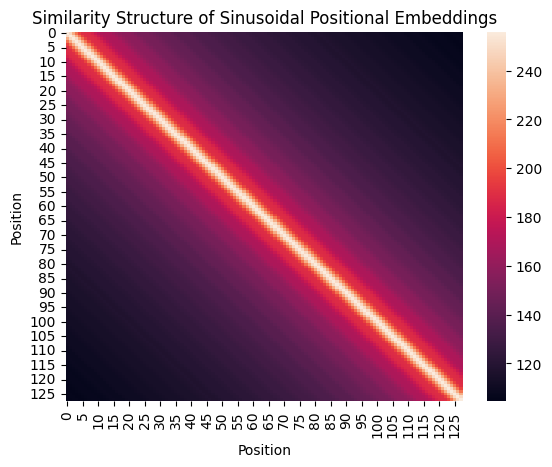

In [27]:
pe = get_sinusoidal_positional_embeddings(128, d_model)

#Your code here
pe_similarity = pe @ pe.T
sns.heatmap(pe_similarity)
plt.title('Similarity Structure of Sinusoidal Positional Embeddings')
plt.xlabel('Position')
plt.ylabel('Position')
plt.show()



[Your markdown here]

The similarity heatmap
$$
S_{ij} = \langle PE_i, PE_j \rangle
$$
shows a strong bright diagonal, meaning that each position is most similar to itself and to nearby positions. As the distance $|i-j|$ increases, the similarity gradually decreases, with smooth oscillatory patterns caused by the sine and cosine components at different frequencies.

This structure is exactly what sinusoidal positional embeddings are designed to model: they encode **absolute position** through a unique combination of sinusoidal frequencies, while also making **relative distances** between positions recoverable from inner products. Nearby positions have similar embeddings, and distant positions become less similar in a predictable, periodic way.

From the plot, we clearly observe this intended behavior, so the sinusoidal positional embeddings appear to effectively capture both positional identity and relative ordering information required by the Transformer.


### Multi-Head Attention

The core operation in a Transformer is multi-head attention, sometimes called self-attention. In this problem, we will implement multi-head attention in numpy from scratch, given the trained parameters of the model.

The input is a sequence of vectors $X = (x_1, ..., x_n) \in \reals^{n \times d_{model}}$. For each attention head $h \in [n_h]$, the parameters consist of a query projection matrix $W_q^h \in \reals^{d_{model} \times d_h}$, a key projection matrix $W_k^h \in \reals^{d_{model} \times d_h}$, and a value projection matrix $W_k^h \in \reals^{d_{model} \times d_h}$. Here, $d_h$ is the "head dimension", taken to be $d_{model} / n_h$ (to maintain the same dimensionality between the input and output). The algorithm, for each head, is the following:
1. Compute the queries $Q = X W_q^h$, keys $K = X W_k^h$, and values $V = X W_v^h$. Note that the linear maps are applied independently for each token across the embedding dimension (not sequence dimension), such that $Q, K, V \in \reals^{n \times d_h}$.
2. Compare the queries and keys via inner products to get an $n \times n$ attention matrix $A = \mathrm{Softmax}(Q K^{\intercal}) \in \reals^{n \times n}$.
3. Use the attention scores $A$ to select values, producing the output of the self-attention head: $\mathrm{head}_h = A V \in \reals^{n \times d_h}$.
We then concatenate the retrieved values across all heads, and apply a final linear map. Putting this all together yields:
$$
\begin{align}
    \mathrm{head}_h &= \mathrm{Softmax}((X W_q^h) (X W_k^h)^{\intercal}) X W_v^h\\
    \mathrm{MultiHeadAttention}(X) &= \mathrm{concat}(\mathrm{head}_1, ..., \mathrm{head}_{n_h}) W_o\\
\end{align}
$$

### Problem 2.4: Implement multi-head attention

In [28]:
# first, implement softmax and causal masking
def softmax(x, axis=-1):
    """
    Numerically stable softmax over the given axis.
    """
    # subtract max for numerical stability
    x_max = np.max(x, axis=axis, keepdims=True)
    x_shifted = x - x_max
    exp_x = np.exp(x_shifted)
    sum_exp = np.sum(exp_x, axis=axis, keepdims=True)
    return exp_x / sum_exp

def apply_presoftmax_causal_mask(attn_scores):
    """
    Apply a causal mask to the attention scores:
    set all entries above the main diagonal to -inf,
    so each position can only attend to itself and previous positions.

    attn_scores: (..., seq_len, seq_len)
    """
    seq_len = attn_scores.shape[-1]

    # upper triangle (k=1) is "future" positions
    mask = np.triu(np.ones((seq_len, seq_len), dtype=bool), k=1)

    # copy to avoid in-place modification surprises
    masked_scores = attn_scores.copy()
    masked_scores[..., mask] = -np.inf
    return masked_scores

In [29]:
# check your implementation
x = np.ones((4,4))
softmax_x = softmax(x, axis=1)
print("Softmax:\n", softmax_x)

# apply_presoftmax_causal_mask test
attn_scores = np.ones((4,4))
masked_scores = apply_presoftmax_causal_mask(attn_scores)
print("Masked Attention Scores:\n", masked_scores)

masked_softmax = softmax(masked_scores, axis=-1)
print("Masked Softmax:\n", masked_softmax)

Softmax:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Masked Attention Scores:
 [[  1. -inf -inf -inf]
 [  1.   1. -inf -inf]
 [  1.   1.   1. -inf]
 [  1.   1.   1.   1.]]
Masked Softmax:
 [[1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.25       0.25       0.25       0.25      ]]


Expected results:
```
Softmax:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Masked Attention Scores:
 [[  1. -inf -inf -inf]
 [  1.   1. -inf -inf]
 [  1.   1.   1. -inf]
 [  1.   1.   1.   1.]]
Masked Softmax:
 [[1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.25       0.25       0.25       0.25      ]]
```

In [30]:

def multi_head_attention(x, params, layer_prefix='layers.0'):
    """
    Compute multi-head self-attention.

    Args:
        x (np.array): input tensor, shape (n, d_model)
        params (dict): dictionary containing the model parameters
        layer_prefix (str): prefix of parameter names corresponding to the layer
        verbose (bool): whether to print intermediate shapes
    """

    # get parameters of multi-head attention layer
    wq = params[f'{layer_prefix}.attention.wq.weight'].T # (d_model, d_model)
    wk = params[f'{layer_prefix}.attention.wk.weight'].T # (d_model, d_model)
    wv = params[f'{layer_prefix}.attention.wv.weight'].T # (d_model, d_model)
    wo = params[f'{layer_prefix}.attention.wo.weight'].T # (d_model, d_model)

    head_dim = d_model // n_heads # dimension of each head
    attn_scale = 1 / math.sqrt(head_dim) # scaling factor for attention scores

    # the wq, wk, wv, wo matrices contain weights for all heads, concatenated
    # first, we split wq, wk, wv, wo into heads
    # note: there are more efficient implementations, but this is more verbose/pedagogical
    wq = wq.reshape(d_model, n_heads, head_dim).transpose(1, 0, 2) # (n_heads, d_model, head_dim)
    wk = wk.reshape(d_model, n_heads, head_dim).transpose(1, 0, 2) # (n_heads, d_model, head_dim)
    wv = wv.reshape(d_model, n_heads, head_dim).transpose(1, 0, 2) # (n_heads, d_model, head_dim)

    head_outputs = []
    for head in range(n_heads):

        # get head-specific parameters (these are the query/key/value projections for this head)
        # your code ehre
        wqh = wq[head] # (d_model, head_dim)
        wkh = wk[head] # (d_model, head_dim)
        wvh = wv[head] # (d_model, head_dim)


        # compute queries, keys, values
        # your code here
        q = x @ wqh      # (n, head_dim)
        k = x @ wkh      # (n, head_dim)
        v = x @ wvh      # (n, head_dim)

        # compute attention scores
        # your code here
        # compute dot product
        attn_scores = q @ k.T # (n, n)
        # multiply by scaling factor
        attn_scores = attn_scores * attn_scale # (n, n)

        # apply causal mask
        attn_scores = apply_presoftmax_causal_mask(attn_scores) # (n, n)
        # apply softmax
        attn_scores = softmax(attn_scores, axis=-1) # (n, n)

        # apply attention scores to values
        # your code here
        head_out = attn_scores @ v # (n, head_dim)

        # store the head output
        head_outputs.append(head_out)

    # concatenate all head outputs
    head_outputs = np.concatenate(head_outputs, axis=-1) # (n, d_model)

    # apply output linear map W_o to concatenated head outputs
    # your code here
    output = head_outputs @ wo # (n, d_model)

    return output

#### Test your Attention implementation

To test if you have the correct implementation, you can run the following
test line. We show the expected output if your implementation is correct.

In [31]:
multi_head_attention(np.ones((block_size, d_model)), transformer_model_weights)[:3, :5]

array([[-0.61194002, -0.31581021,  0.17525476, -0.03176344,  0.23671877],
       [-0.61194002, -0.31581021,  0.17525476, -0.03176344,  0.23671877],
       [-0.61194002, -0.31581021,  0.17525476, -0.03176344,  0.23671877]])

Expected output:

```
array([[-0.61194002, -0.31581021,  0.17525476, -0.03176344,  0.23671877],
       [-0.61194002, -0.31581021,  0.17525476, -0.03176344,  0.23671877],
       [-0.61194002, -0.31581021,  0.17525476, -0.03176344,  0.23671877]])
```

### MLP

Each Transformer layer (i.e., block) consists of two operations: 1) (multi-head) self-attention, which enables exchange of information between tokens, and 2) a multi-layer perceptron, which processes each token independently. A Transformer model is essentially just alternating between these two operations. In this problem, we will implement the multi-layer perceptron step. Typically, the MLP at each layer is simply a two-layer (one hidden layer) MLP or Feed Forward Network. In our model, we use a ReLU activation in the hidden layer, though other activations are possible. The same MLP network is applied to each token embedding in the sequence independently.

Given $X = (x_1, ..., x_n) \in \reals^{n \times d_{model}}$, we apply the MLP as follows:

$$\mathrm{MLP}(X) = \mathrm{ReLU}(X W_1) W_2$$

Note that we don't use biases for simplicity.

### Problem 2.5: Implement the MLP

Next, we need to apply the multi-layer perceptron in each layer. Complete the implementation below.

In [ ]:
def relu(x):
    return np.maximum(x, 0)

def mlp(x, params, layer_prefix='layers.0'):
    # get MLP parameters
    w1 = params[f'{layer_prefix}.feed_forward.0.weight'].T # (d_model, d_ff)
    w2 = params[f'{layer_prefix}.feed_forward.2.weight'].T # (d_ff, d_model)

    # Your code here
    o = ... # (n, d_model)

    return o

#### Test your MLP implementation

To test if you have the correct MLP implementation, you can run the following
test line. We show the expected output if your implementation is correct.

In [ ]:
mlp(np.ones((block_size, d_model)), transformer_model_weights)[:3, :5]

Expected output:

```
array([[ 0.36650751, -0.02109491,  0.13528369, -0.0459696 ,  0.2035102 ],
       [ 0.36650751, -0.02109491,  0.13528369, -0.0459696 ,  0.2035102 ],
       [ 0.36650751, -0.02109491,  0.13528369, -0.0459696 ,  0.2035102 ]])
```

### Problem 2.6: Implement Layer Normalization

Layer Normalization is a technique that normalizes the inputs across the features of a layer to stabilize and accelerate training in deep neural networks. It rescales activations to have zero mean and unit variance *within* each layer, then applies a learned gain and shift. In Transformers, LayerNorm is applied before or after sublayers (like attention and feedforward blocks), stabilizing training and maintaining consistent scaling across tokens and layers.

In this problem, we will implement layer normalization. For a vector of activations $x \in \reals^d$, layer normalization returns the normalized feature vector
$$\mathrm{LayerNorm}(x) = \frac{x - E[X]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta,$$
where $\gamma \in \reals^d$ is the weight parameter, and $\beta \in \reals^d$ is the bias parameter. Here, $E[\cdot]$ and $\mathrm{Var}[\cdot]$ indicates the mean and variance over the embedding dimension $d_{\mathrm{model}}$.

In [ ]:
def layer_norm(x, params, layer_prefix='layers.0', norm_type='attn_norm', norm_eps=1e-5):
    # get layer norm params
    weight = params[f'{layer_prefix}.{norm_type}.weight'] # (d_model,)
    bias = params[f'{layer_prefix}.{norm_type}.bias'] # (d_model,)

    # your code here
    ...

    return normed_x

#### Test your LayerNorm implementation

To test if you have the correct LayerNorm implementation, you can run the following test line. We show the expected output if your implementation is correct.

In [ ]:
layer_norm(np.arange(block_size * d_model).reshape(block_size, d_model), transformer_model_weights, layer_prefix='layers.0', norm_type='attn_norm')[:3, :5]

Expected Output:
```
array([[-1.76364724, -1.75155978, -1.7455241 , -1.74605486, -1.72934376],
       [-1.76364724, -1.75155978, -1.7455241 , -1.74605486, -1.72934376],
       [-1.76364724, -1.75155978, -1.7455241 , -1.74605486, -1.72934376]])
```

### Problem 2.7: Exploring Normalization in Residual Architectures

Transformers are a type of *residual network*. At each layer, the embeddings of each token are iteratively refined by adding the result of a non-linear learnable transformation (either attention or MLP). In general, a residual architecture has the form
$$x^{(\ell + 1)} = x^{(\ell)} + \mathcal{F}(x^{(\ell)}),$$
where $x^{(\ell)}$ is the internal representation at layer $\ell$ and $\mathcal{F}(\cdot)$ is a learned transformation. You can think of $\mathcal{F}(\cdot)$ as modeling the *residual* $x^{(\ell)} \mapsto x^{(\ell + 1)} - x^{(\ell)}$ rather than needing to directly model the full $x^{(\ell)} \mapsto x^{(\ell + 1)}$ map. This improves training stability and mitigates vanishing gradient problems.

There are different ways that normalization can be applied to residual networks. The form above includes no normalization.

In the original Transformer paper, the authors use so-called "post-normalization", where the normalization is applied *after* the residual block:
$$x^{(\ell + 1)} = \mathrm{LayerNorm}(x^{(\ell)} + \mathcal{F}(x^{(\ell)})).$$

In modern architectures, it is more common to use "pre-normalization", where the normalization before the learned transformation:
$$x^{(\ell + 1)} = x^{(\ell)} + \mathcal{F}(\mathrm{LayerNorm}(x^{(\ell)})).$$

In this problem, we will explore the effects of normalization on the magnitude of the feature vectors at each layer. Complete the code below to implement each form of normalization: 1) no norm, 2) post-norm, 3) pre-norm. Plot the average embedding norm across layers for each form of normalization. Interpret the results. Does this shed light onto why normalization is a useful empirical technique to stabilize and accelerate training?

In [ ]:
# Experiment: compare NoNorm, Pre-LN, Post-LN for a stack of feedforward blocks
np.random.seed(0)

seq_len = block_size
d_model = D
d_ff = F * D
n_layers_exp = 24

# shared random input X0
X0 = np.random.randn(seq_len, d_model)

def simple_layer_norm(x, eps=1e-5):
    # for purposes of exploration, implement a simple layer norm with weight = 1 and bias = 0

    # your code here
    ...

    return norm_x

# random FFN blocks to play the role of $\mathcal{F}$
# initialize independent W1/W2 per layer
W1_list = [np.random.randn(d_model, d_ff) * (1.0 / np.sqrt(d_model)) for _ in range(n_layers_exp)]
W2_list = [np.random.randn(d_ff, d_model) * (1.0 / np.sqrt(d_ff)) for _ in range(n_layers_exp)]

def ffn(x, W1, W2):
    return relu(np.dot(x, W1)).dot(W2)

In [ ]:
# complete the implementation
def run_scheme(scheme_name):
    x = X0.copy()
    norms = [np.mean(np.linalg.norm(x, axis=1))]  # layer 0
    for i in range(n_layers_exp):
        W1, W2 = W1_list[i], W2_list[i]
        # residual without normalization
        if scheme_name == 'no_norm':
            x = ... # your code here

        # apply "pre-norm" normalization
        elif scheme_name == 'pre_ln':
            x = ... # your code here

        # apply "post-norm" normalization
        elif scheme_name == 'post_ln':
            x = ... # your code here
        else:
            raise ValueError(scheme_name)

        # compute norm of each token embedding at current layer
        avg_norm_this_layer = np.mean(np.linalg.norm(x, axis=1)) # your code here
        norms.append(avg_norm_this_layer)
    return np.array(norms)

In [ ]:

schemes = ['no_norm', 'pre_ln', 'post_ln']
results = {s: run_scheme(s) for s in schemes}

# Plot
plt.figure(figsize=(6,4))
layers = np.arange(0, n_layers_exp + 1)
plt.plot(layers, results['no_norm'], marker='o', label='No Norm')
plt.plot(layers, results['pre_ln'], marker='o', label='Pre-LayerNorm')
plt.plot(layers, results['post_ln'], marker='o', label='Post-LayerNorm')
plt.xlabel('Layer index')
plt.ylabel('Mean token L2 norm')
plt.title('Residual stream norm vs depth: No Norm / Pre-LN / Post-LN')
plt.xticks(layers)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[Your Markdown Here]

### Final Prediction Layer

A Transformer model iteratively applies multi-head attention and MLP layers to process the input. This produces a processed representation of shape $n \times d_{model}$. To make the final prediction (e.g., predict the next token), we need to map the $d_{model}$-dimensional embedding vectors to logits over the output vocabulary. To do this, we simply apply a linear map that maps from $d_{model}$ to $\mathtt{vocab\_size}$.

The starter code for this is given below; you need to complete it.

### Problem 2.8: Implement the prediction layer as logits.

In [ ]:
def prediction_head(x, params):
    # get needed parameters
    w = params['fc_out.weight'].T # (d_model, vocab_size)
    b = params['fc_out.bias'] # (vocab_size,)

    # Your code here
    logits = ... # (n, vocab_size)

    return logits

### Test the prediction head

In [ ]:
prediction_head(np.ones((block_size, d_model)), transformer_model_weights)[:3, :5]

```
array([[-1.52472634, -0.92704511, -0.07956709, -0.27001108, -0.2583226 ],
       [-1.52472634, -0.92704511, -0.07956709, -0.27001108, -0.2583226 ],
       [-1.52472634, -0.92704511, -0.07956709, -0.27001108, -0.2583226 ]])
```

### Putting it all together: A Full Transformer Language Model

We are now ready to put this all together to assemble our Transformer Language Model. Recall that the Transformer architecture consists of iteratively applying multi-head attention and MLPs. Each time we apply attention or the MLP, we also apply a *residual connection*: $X^{(\ell + 1)} = X^{(\ell)} + F(X^{(\ell)})$. This can be interpreted as a mechanism to enable easy communication between different layers (some people call refer to this idea as the "residual stream"). Real Transformers also include layer normalization in each layer, but we omit this for simplicity in this problem.

The full algorithm is given below:
1. Embed the tokens using the embedding lookup table: $(t_1, ..., t_n) \mapsto (E_{t_1}, ..., E_{t_n}) =: X^{(0)}$
2. Add the positional embeddings: $X^{(0)} \gets X^{(0)} + (PE_1, ..., PE_n)$
3. For each layer $\ell = 1, ..., L$:
    1. Apply Multi-Head Attention: $\tilde{X}^{(\ell)} \gets X^{(\ell-1)} + \mathrm{MultiHeadAttention}(\mathrm{LayerNorm}(X^{(\ell-1)}))$.
    2. Apply the MLP: $X^{(\ell)} \gets \tilde{X}^{(\ell)} + \mathrm{MLP}(\mathrm{LayerNorm}(\tilde{X}^{(\ell)}))$.
4. Compute the logits

### Problem 2.9: Complete the implementation

Complete the starter code below, which takes embeddings, adds positional encoding,
and then adds the attention and MLP components to each layer. Remember that
everything is added together, with the computations in one layer added to the outputs of the previous layer, forming the "residual stream".

Hint: to complete the implementation, you will need to use the `layer_norm`, `multi_head_attention`, `mlp`, and `prediction_head` functions you implemented above. Recall that these functions take `param` as input (which are the weights of the pre-trained model). They use the `layer_prefix` argument to fetch the weights at the given layer. For example, `layer_prefix=f'layers.{i}'` will the corresponding module for layer `i`. Additionally, since each layer has two LayerNorms, one for the attention module and one for the MLP module, the `layer_norm` function additionally takes `norm_type` argument, which can be `'attn_norm'` or `'ff_norm'`.

In [ ]:
def transformer(tokens, params):
    # tokens: (n,) integer array
    # params: dictionary of parameters

    # map tokens to embeddings using embed_tokens
    x = embed_tokens(tokens, params) # (n, d_model)

    # add positional embeddings
    pe = get_sinusoidal_positional_embeddings(x.shape[0], x.shape[1]) # (n, d_model)
    # your code here
    x += pe # (n, d_model)

    # transformer blocks
    for i in range(n_layers):

        # compute multi-head self-attention and add residual with pre-normalization
        # your code here
        normed_x = ... # (n, d_model)
        attn_out = ... # (n, d_model)

        # residual connection
        x = ... # (n, d_model)

        # compute MLP and add residual with pre-normalization
        # your code here
        normed_x = ... # (n, d_model)
        mlp_out = ... # (n, d_model)
        # residual connection
        x = ... # (n, d_model)

    # compute logits via the prediction_head
    # your code here
    logits = ... # (n, vocab_size)

    return logits

### Test your implementation

You can check your implementation against the expected output below.

In [ ]:
transformer([0, 1, 2], params=transformer_model_weights)[:3, :5]

Expected Output:

```
array([[-3.30795902, -1.94197185, -0.67287023, -1.7162725 , -1.541589  ],
       [-4.15893294, -1.8336369 , -2.26268609, -2.63614073, -2.48212268],
       [-3.51487274, -2.31248397, -3.52562574, -3.18057025, -1.76104193]])
``````

### Generate some text

Below, we provide some code for generating text from a Transformer language model. The sampling procedure is *autoregressive*. This means that we input some text to the model and it outputs a distribution over next tokens. We sample the next token and append it to the text, then repeat the procedure.

### Problem 2.10: Complete the next token generator

Complete the next token generator, but filling in the missing code below. This uses "temperature" to focus on the more probable tokens in a given context (as the temperature decreases).

In [ ]:
def generate_with_transformer(prefix_text, params, max_len=128, greedy=False, temperature=0.9):
    # encode seed text
    prefix_tokens = list(enc.encode(prefix_text))

    # initialize generated tokens
    generated_tokens = prefix_tokens

    # generate new tokens
    for i in range(max_len):
        # predict next token
        logits = transformer(generated_tokens, params)
        # hint: logits[-1] corresponds to prediction of the next token
        if greedy:
            # Your code here
            next_token = ...
        else:
            # Your code here
            next_token = ...

        # add next token to generated tokens
        generated_tokens.append(next_token)

    # This converts the tokens to text, using the tiktoken decoder:
    generated_text = enc.decode(generated_tokens)

    return generated_text

### Test your implementation by generating text. You're the Bard!

Use your implementation to generate text according to the model. Generate text at different temperatures. Do the results make sense? Comment on the quality of the model. What changes to the model would lead to better results? Comment in the Markdown cell below.

In [ ]:
 prefix_text = """STUDENT:
 O though Transformer, wrought of mind and code,
 Thou art the loom where language weaveth thought!
 Each token, like a spark of meaning sown,
 Attendeth all, and all attend to one."""

#prefix_text = """HAMLET:
#To be, or not to be: that is the question"""

In [ ]:
generated_text = generate_with_transformer(prefix_text, transformer_model_weights, greedy=True, max_len=128)
print(generated_text)

In [ ]:
generated_text = generate_with_transformer(prefix_text, transformer_model_weights,
    greedy=False, temperature=0.8, max_len=128)
print(generated_text)

[Your markdown here]